### Dependencies

In [19]:
import pandas as pd
import numpy as np
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
import datetime
import zipfile

from dask import bag
from dask.diagnostics import ProgressBar

from sklearn.mixture import GaussianMixture

In [22]:
#print(sys.path, sys.executable)

### Explorations

In [13]:
ROOT_DIR = os.getcwd()
zf = zipfile.ZipFile(ROOT_DIR + '/data/train_set.csv.zip') 
df = pd.read_csv(zf.open('train_set.csv'))

df.rename(index=str, columns={"visitor_id": "visitor_id", " visits": "visits"}, inplace = True)

In [14]:
def convert_strings(row):
    
    result_list = [int(s) for s in row['visits'].split() if s.isdigit()]
    
    return result_list

df['visits'] = df.apply(convert_strings, axis = 1)

In [15]:
def print_info(dataframe):
    
    print('There are {} unique visitors'.format(dataframe['visitor_id'].nunique()), '\n')
    print('There is average of {} visits in the dataset per visitor'.format(np.mean(
                                                    dataframe['visits'].apply(lambda x: len(x))),'\n'))
          
print_info(df)                                                                                                                

There are 300000 unique visitors 

There is average of 111.81511 visits in the dataset per visitor


Text(0, 0.5, 'Dencity')

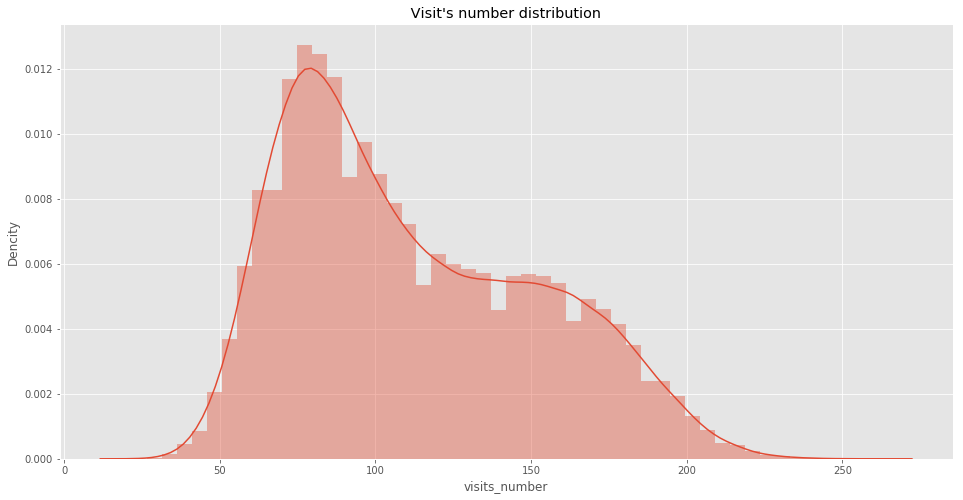

In [10]:
### Groupby the number of visits and visualize. Probably we have two groups from two Gaussians.

df['visits_number'] = df['visits'].apply(lambda x: len(x))
plt.style.use('ggplot')
plt.figure(figsize = (16,8))
sns.distplot(df['visits_number'])
plt.title(''' Visit's number distribution ''')
plt.ylabel('Dencity')

In [45]:
df['mean_diff'] = 0.
df['std_diff'] = 0.
df['diff_list'] = 0.
df['max_diff_to_len'] = 0.
df['min_diff_to_len'] = 0.

def explore_differences(row):
    
    diff_series = pd.Series(row['visits']).diff().iloc[1:]
    
    row['mean_diff'] = np.mean(diff_series)
    row['std_diff'] = np.std(diff_series)
    row['diff_list'] = list(diff_series)
    row['max_diff_to_len'] = max(diff_series)/len(diff_series)
    row['min_diff_to_len'] = min(diff_series)/len(diff_series)

    return row

df = df.apply(explore_differences, axis = 1)

Text(0, 0.5, 'Dencity')

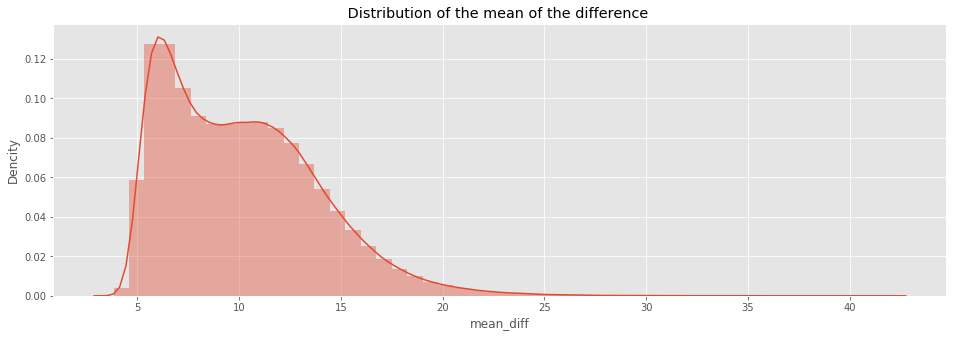

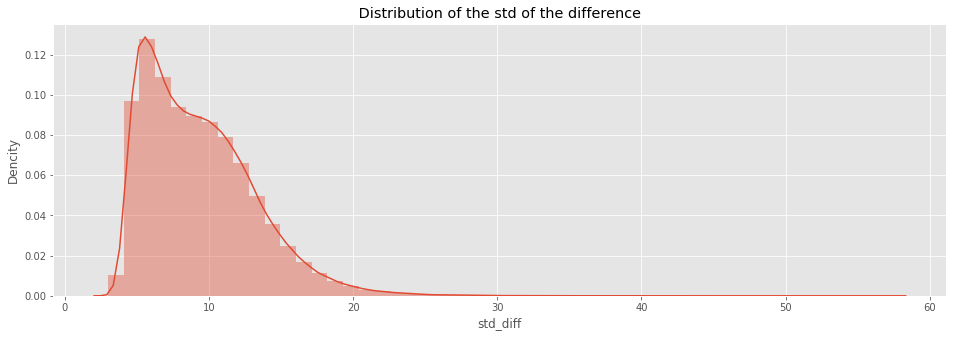

In [27]:
### Visualise diffs' distribution
plt.figure(figsize = (16,5))
sns.distplot(df['mean_diff'])
plt.title(''' Distribution of the mean of the difference  ''')
plt.ylabel('Dencity')

plt.figure(figsize = (16,5))
sns.distplot(df['std_diff'])
plt.title(''' Distribution of the std of the difference ''')
plt.ylabel('Dencity')

In [44]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
years = ['1','2','3']

#@timeit(repeat=3, number=100)
def create_empty_cols(dataframe):
    
    for day in days:
        dataframe[day] = 0.0
    for year in years:
        dataframe[year] = 0.0
    return dataframe

df = create_empty_cols(df)

#@timeit(repeat=3, number=100)
def create_seasonal_features(row):
    
    for i,day in enumerate(days):
        row[day] = sum([x%7 == (i+1)%7 for x in row['visits']])
    
    for i,year in enumerate(years):
        row[year] = sum([x < 365*(i+1) for x in row['visits']])
        
    return row
        
df = df.apply(create_seasonal_features, axis = 1)

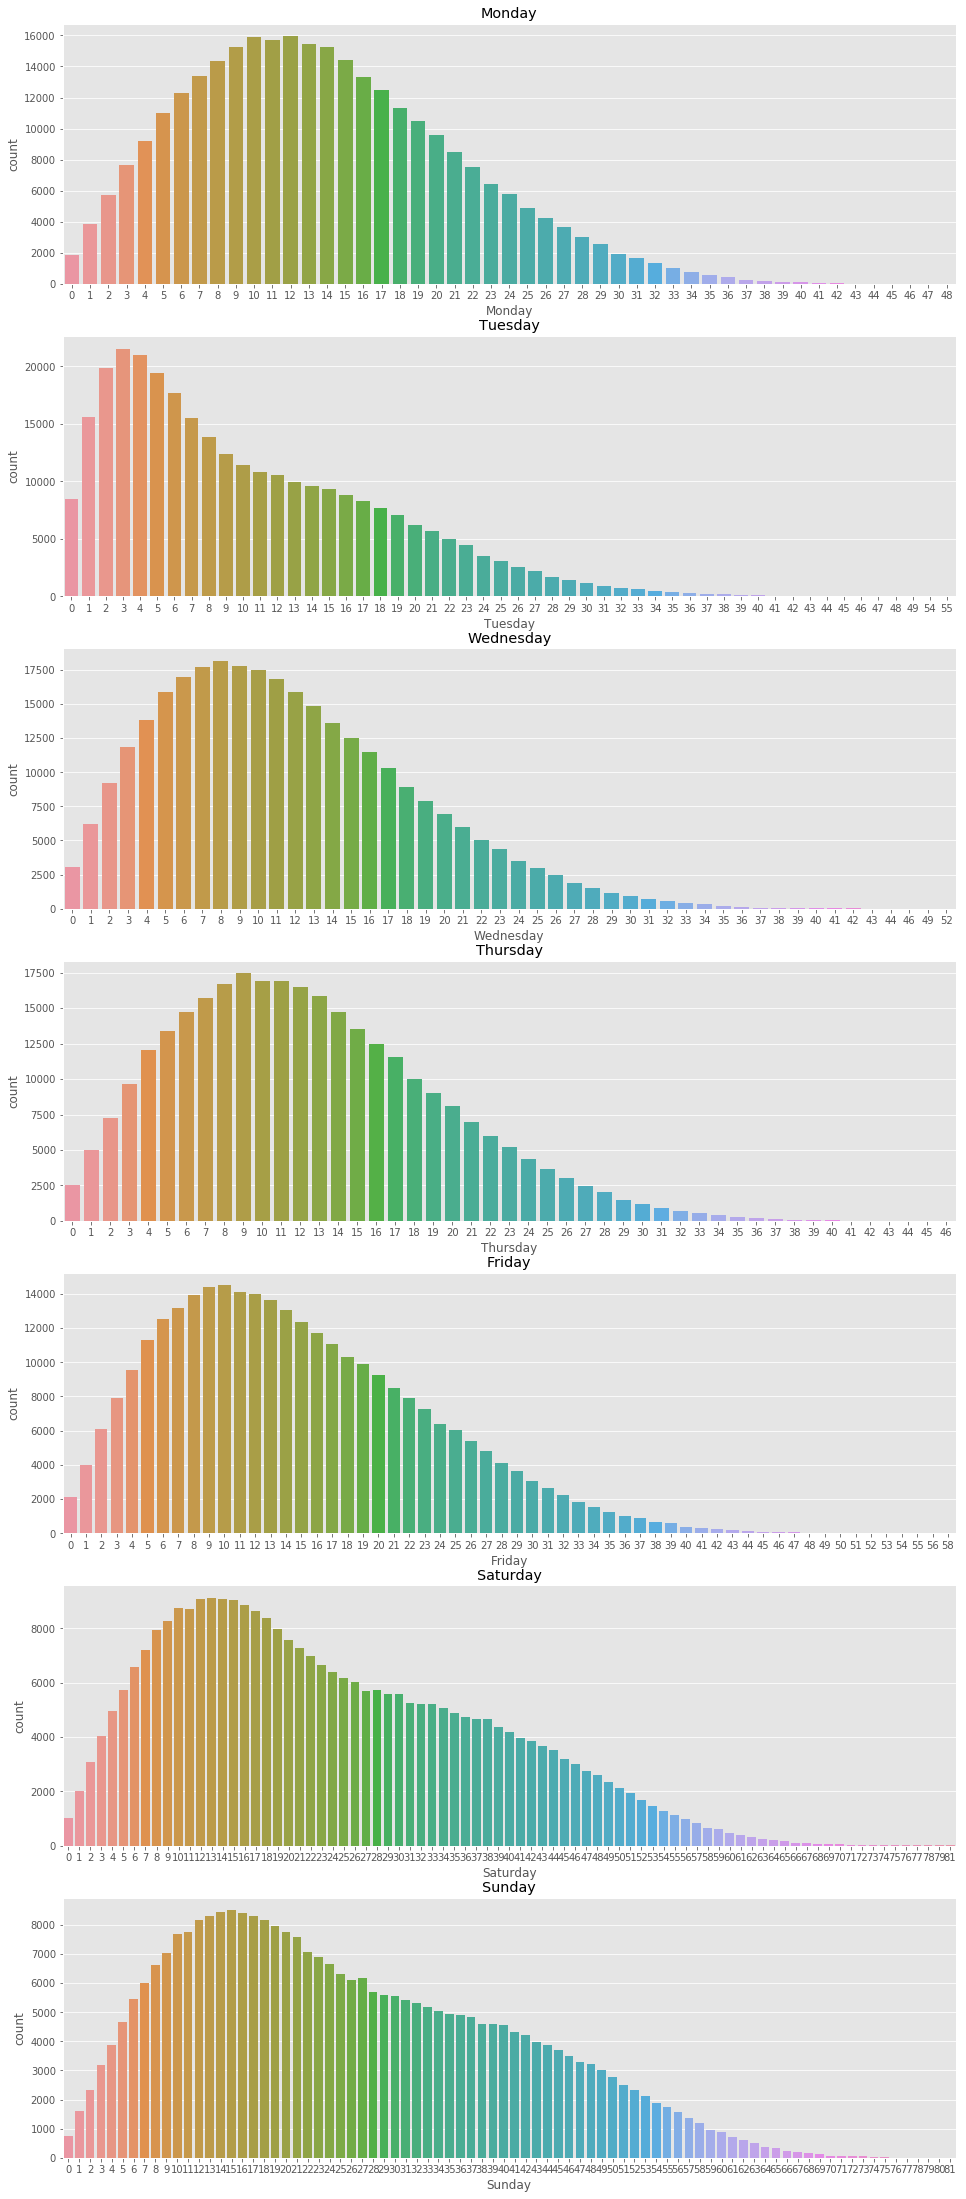

In [54]:
plt.figure(figsize = (16,45))
for i in range(7):
    plt.subplot(8, 1, i+1)
    sns.countplot(df[days[i]])
    plt.title(days[i])

Text(0.5, 1.0, 'Countplot by weekdays')

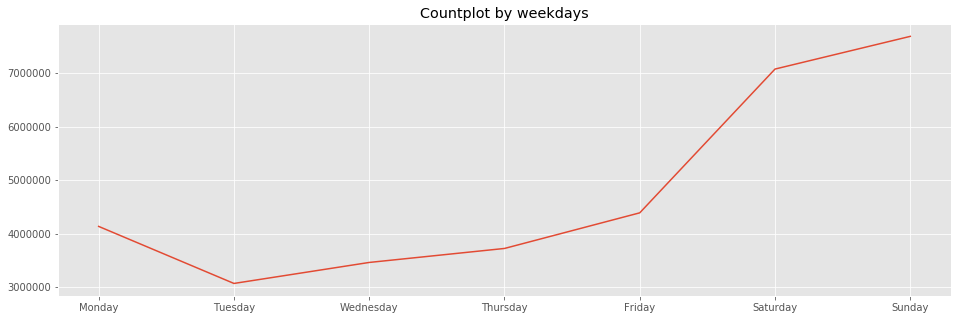

In [59]:
plt.figure(figsize = (16,5))
plt.plot(df[days].sum())
plt.title('Countplot by weekdays')

In [66]:
days_n = 1000
month = 30

for i in range(round(days_n/month)+1):
    df['month_'+str(i+1)] = 0.
    
def split_by_month(row):
    
    for i in range(round(days_n/month)+1):
        row['month_'+str(i+1)] = sum([(x < 30*(i+1)) and (x > 30*(i)) for x in row['visits']])
    return row

df = df.apply(split_by_month, axis = 1)

Text(0.5, 1.0, 'Countplot by Monthes')

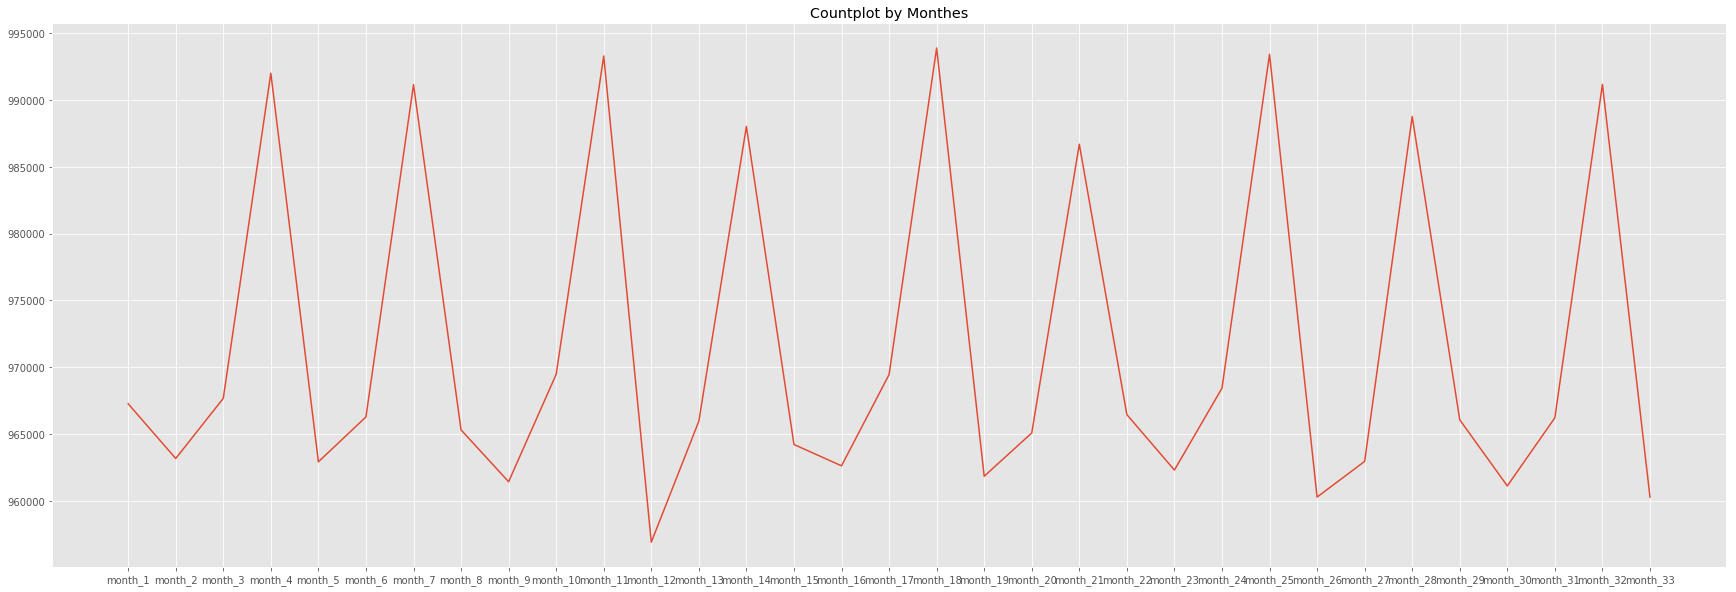

In [73]:
plt.figure(figsize = (30,10))
plt.plot(df[[col for col in df.columns if col.startswith('month_')]].iloc[:,:-1].sum())
plt.title('Countplot by Monthes')

In [9]:
all_visits = []
start_time = datetime.datetime.now()
for visit in df['visits']:
    all_visits += visit

exec_time = datetime.datetime.now() - start_time
print(exec_time)

all_visits = pd.DataFrame(all_visits)
all_visits.columns = ['visits']
all_day_dynamics = all_visits.groupby('visits')['visits'].agg('count')

datetime.timedelta(microseconds=339694)

Text(0.5, 1.0, 'Countplot by Days')

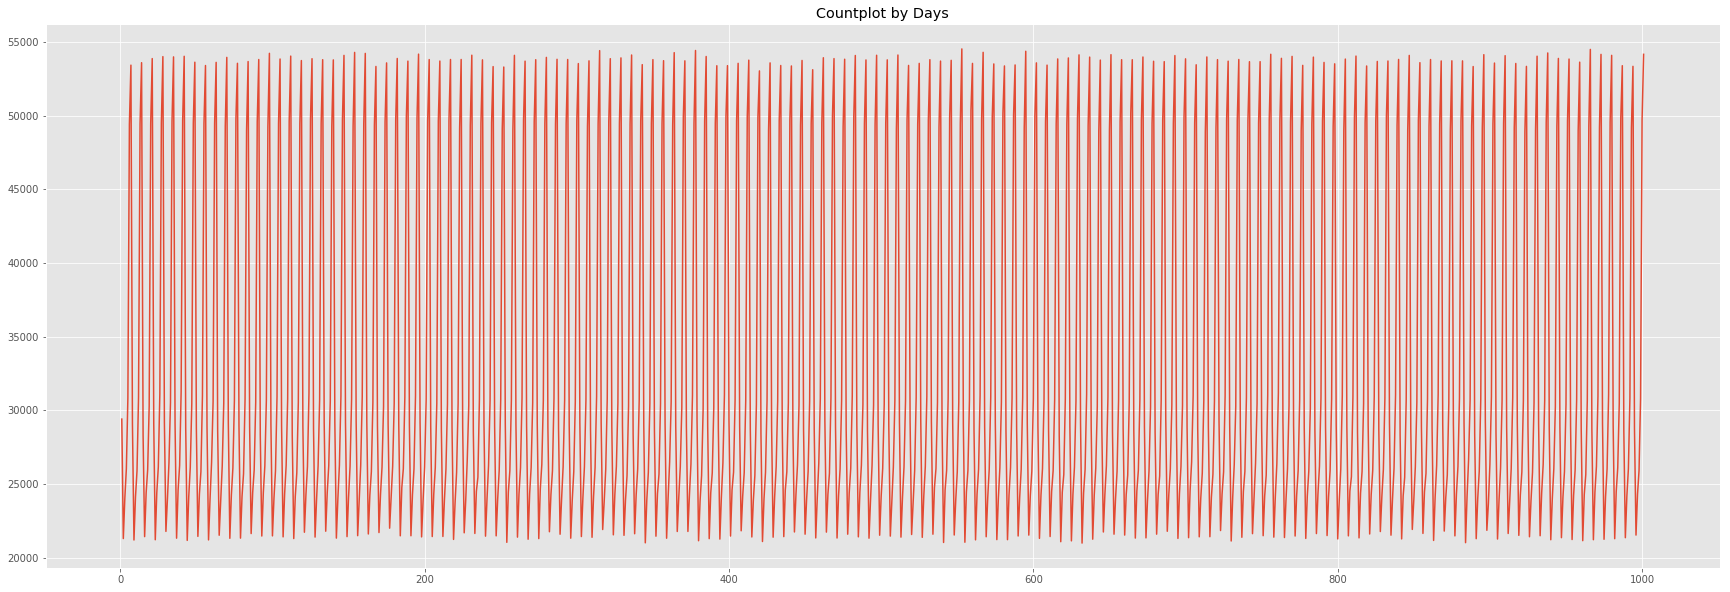

In [16]:
plt.figure(figsize = (30,10))
plt.plot(all_day_dynamics)
plt.title('Countplot by Days')

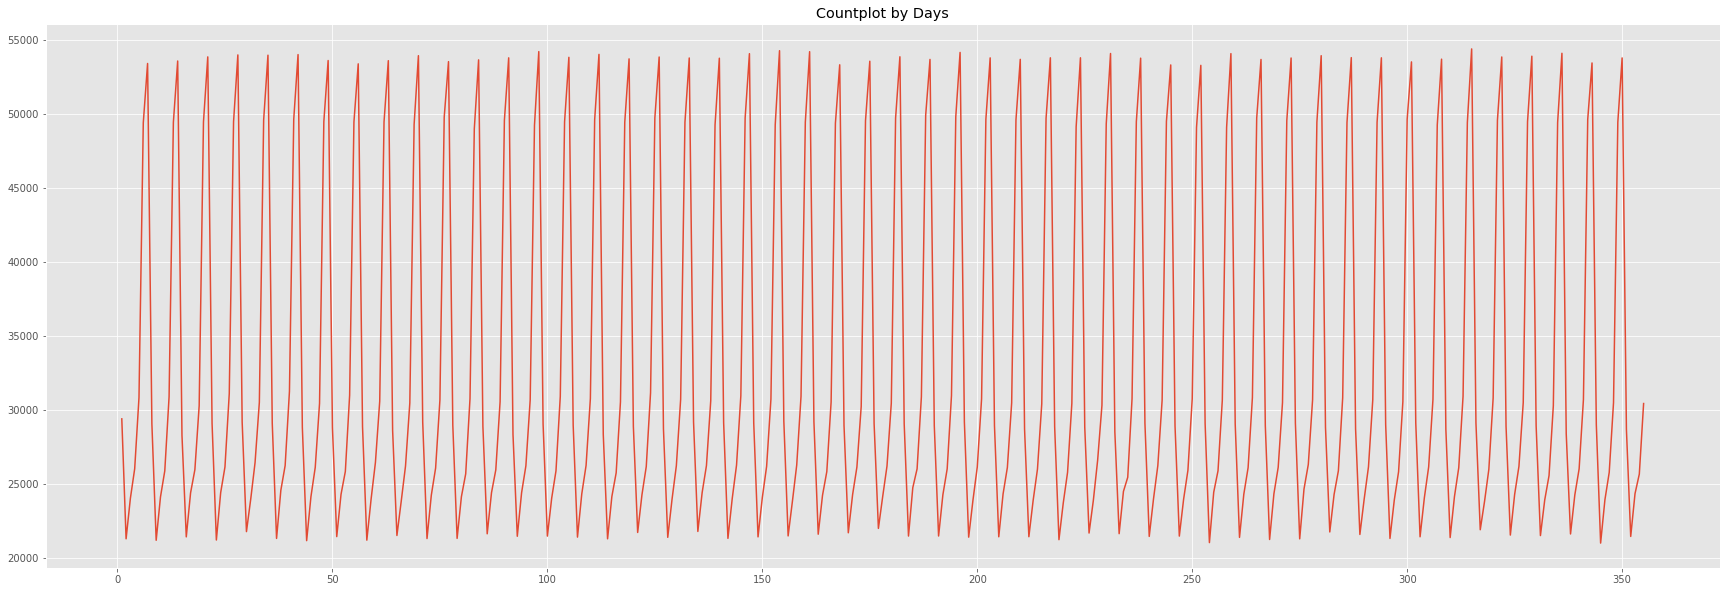

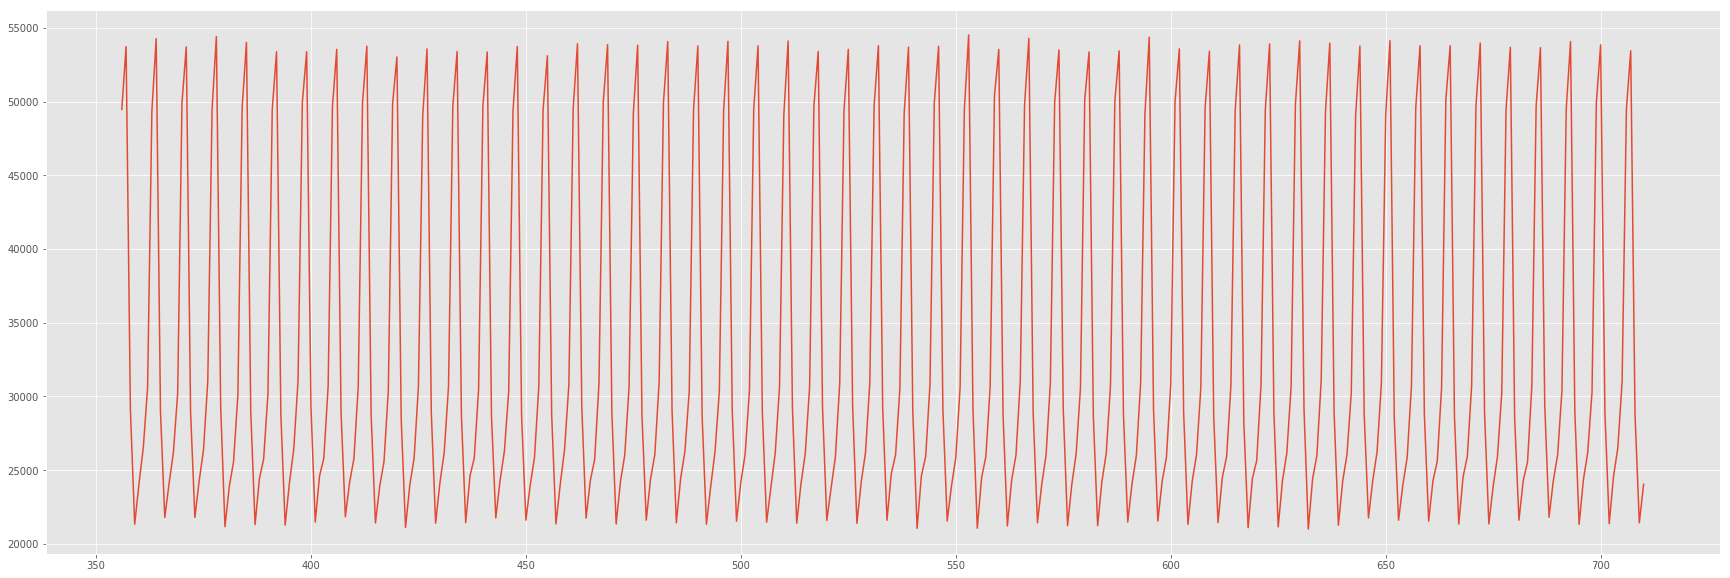

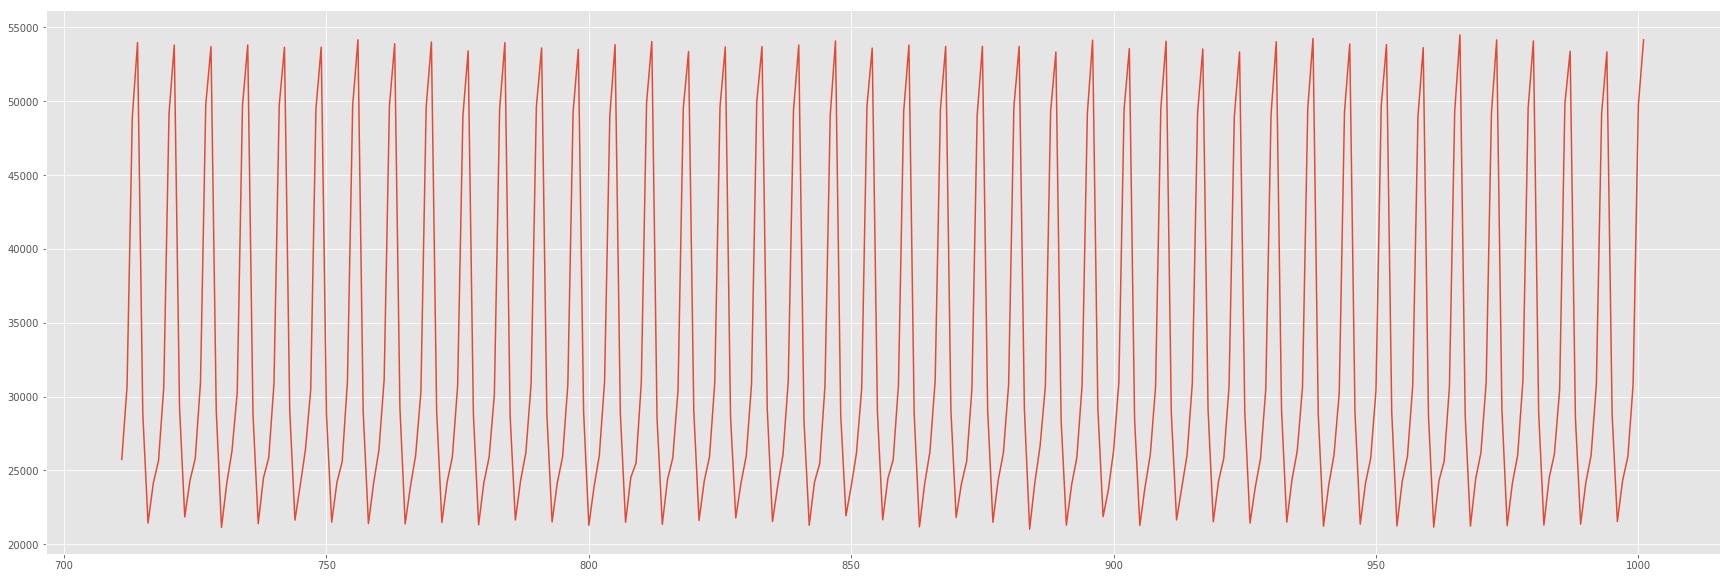

In [22]:
plt.figure(figsize = (30,10))
plt.plot(all_day_dynamics.iloc[:355])
plt.title('Year 1 Visits')
plt.figure(figsize = (30,10))
plt.plot(all_day_dynamics.iloc[355:710])
plt.title('Year 1 Visits')
plt.figure(figsize = (30,10))
plt.plot(all_day_dynamics.iloc[710:])

### Additional features

In [42]:
def define_cluster(dataframe):
    
    X = dataframe['visits_number']
    X = np.array(X).reshape(-1,1)
    gmm = GaussianMixture(n_components=2,random_state = 1).fit(X)
    labels = gmm.predict(X)
    probas = gmm.predict_proba(X)[:,0]
    
    dataframe['Cluster'] = labels
    dataframe['probas'] = probas
    
    return dataframe

df = define_cluster(df)

0    184918
1    115082
dtype: int64


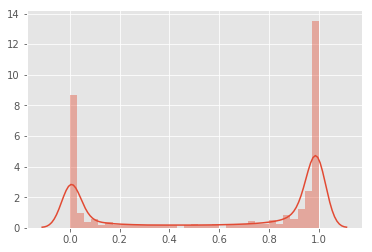

In [43]:
sns.distplot(gmm.predict_proba(X)[:,0])
print(pd.Series(labels).value_counts())

Text(0, 0.5, 'Dencity')

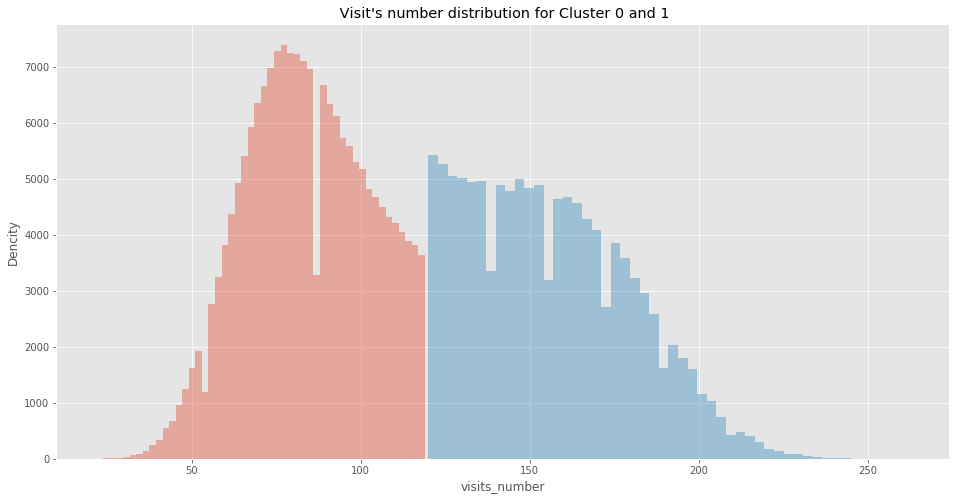

In [44]:
plt.figure(figsize = (16,8))
sns.distplot(df[df['Cluster'] == 0]['visits_number'], kde = False)
sns.distplot(df[df['Cluster'] == 1]['visits_number'], kde = False)
plt.title(''' Visit's number distribution for Cluster 0 and 1''')
plt.ylabel('Dencity')

In [64]:
### count number consecutive number of visits normalized on the visits' number
def count_consecutive_visits(dataframe, n_days = 1):
    
    result = dataframe['diff_list'].apply(lambda x: x.count(n_days))
    
    return result

for i in range(1,8):
    df['consecutive_visits'+str(i)] = count_consecutive_visits(df, n_days = i)


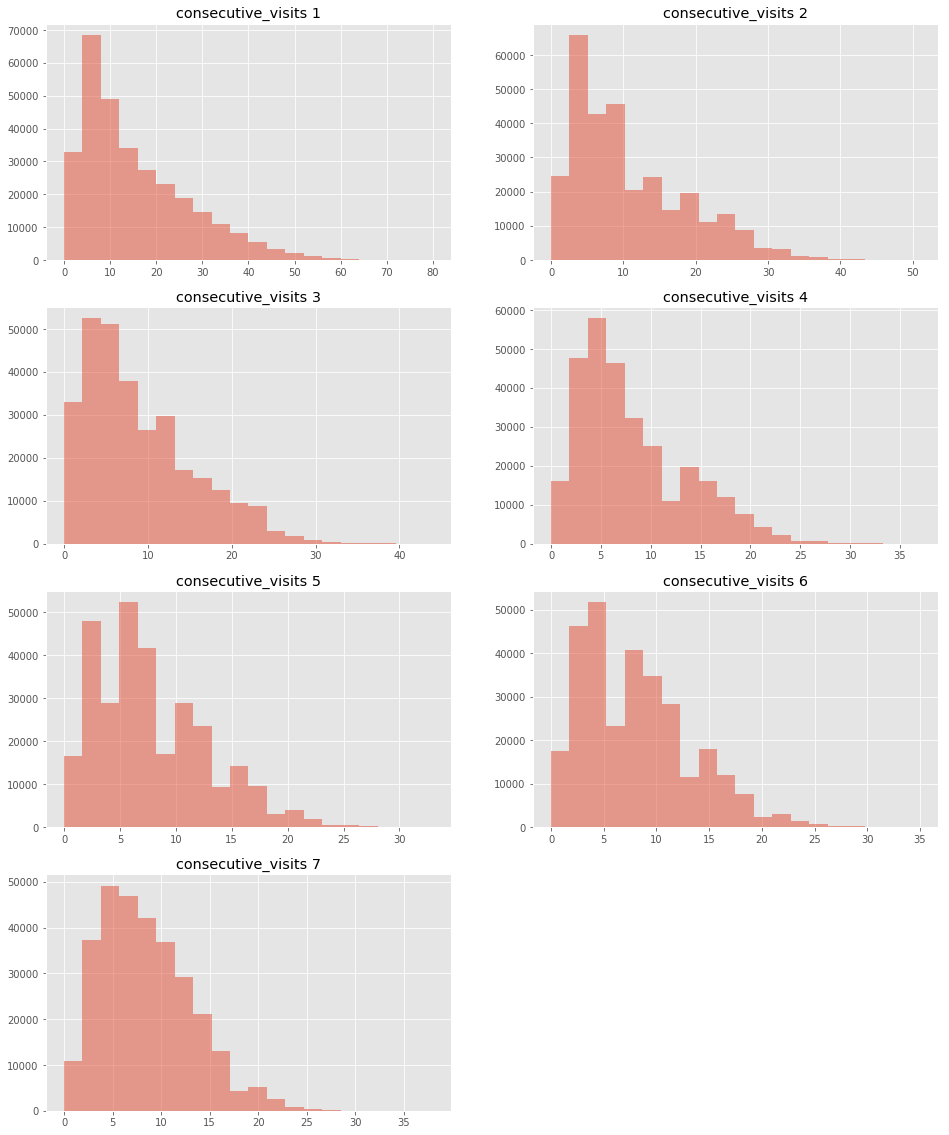

In [79]:
plt.figure(figsize = (16,20))

for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.hist(df['consecutive_visits'+str(i+1)].values, bins = 20, histtype = 'stepfilled', alpha = 0.5)    
    plt.title('consecutive_visits '+str(i+1))
    
    

In [153]:
def convert_visitor(row):
    
    weeks = 143
    days = 7
    Z = np.arange(1,weeks*days+1).reshape(weeks,days)
    df_user = pd.DataFrame(np.in1d(Z.ravel(), row['visits']).reshape(Z.shape).astype(int),
                           columns = ['d1','d2','d3','d4','d5','d6','d7'])
    df_user['week'] = ['w'+str(x) for x in list(range(1,weeks+1))]
    df_user['visitor_id'] = row['visitor_id']
    
    return df_user


In [163]:
start = datetime.datetime.now()
tmp = df[['visitor_id','visits']][df['visitor_id'].isin(list(range(1,300001)))]
datasets = []
for ind, row in tmp.iterrows():
    user_data = convert_visitor(row)
    datasets.append(user_data)
    
datasets = pd.concat(datasets)
datasets.reset_index(drop = True, inplace = True)

print('Memory usage is: ', datasets.memory_usage().sum()/1000000, '\n')
print('Exec time: ', datetime.datetime.now() - start, '\n')

Memory usage is:  3088.80008 

Exec time:  0:11:54.371073 



In [ ]:
datasets.to_csv('dataset_2.csv')

In [16]:
### Form of the new data which will be used for the modelling
datasets = pd.read_csv('dataset_2.csv', usecols=["d1", "d2", "d3", "d4",'d5','d6','d7','week','visitor_id'])
datasets.head(10)

,Unnamed: 0,d1,d2,d3,d4,d5,d6,d7,week,visitor_id
0,0,0,0,0,0,0,0,0,w1,1
1,1,0,0,0,0,0,0,0,w2,1
2,2,0,0,0,0,0,0,0,w3,1
3,3,0,0,0,0,0,0,0,w4,1
4,4,0,1,0,0,0,0,0,w5,1
5,5,0,0,0,0,0,0,0,w6,1
6,6,0,0,0,0,0,0,0,w7,1
7,7,0,0,0,0,0,0,0,w8,1
8,8,0,0,0,0,0,0,0,w9,1
9,9,0,0,0,0,0,0,0,w10,1
